# Ще се опитам да изравня калсовете чрез [SMOTE](https://www.jair.org/media/953/live-953-2037-jair.pdf)

In [81]:
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import itertools

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import LinearSVC

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

%matplotlib inline

In [76]:
train = pd.read_csv('../Data/train.csv')
trainCount = train.shape[0]
print("Train set shape: ", train.shape)
train[:10]

Train set shape:  (159571, 8)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [77]:
X = train.comment_text
X[:10]

0    Explanation\nWhy the edits made under my usern...
1    D'aww! He matches this background colour I'm s...
2    Hey man, I'm really not trying to edit war. It...
3    "\nMore\nI can't make any real suggestions on ...
4    You, sir, are my hero. Any chance you remember...
5    "\n\nCongratulations from me as well, use the ...
6         COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
7    Your vandalism to the Matt Shirvington article...
8    Sorry if the word 'nonsense' was offensive to ...
9    alignment on this subject and which are contra...
Name: comment_text, dtype: object

In [78]:
tags = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
Y = train[tags]
Y[:10]

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
5,0,0,0,0,0,0
6,1,1,1,0,1,0
7,0,0,0,0,0,0
8,0,0,0,0,0,0
9,0,0,0,0,0,0


In [72]:
test = pd.read_csv('../Data/test.csv')
print("Test set shape: ", test.shape)
test[:5]

Test set shape:  (153164, 2)


,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [63]:
x_train, x_test, y_train, y_test = train_test_split(X, Y.threat, random_state=69)

In [52]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          figsize=(9, 7)):
    matrix = confusion_matrix(y_true, y_pred)

    if normalize:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=figsize)
    plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 size=int((figsize[0] / 10) * 38),
                 color="white" if matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [65]:
def show_scores(pipeline, x = X, y = Y):
    for tag in tags:
        print('*****',tag,'*****')
#         print('Cross val score', cross_val_score(pipeline, x, y[tag], cv=3,))
        predict = cross_val_predict(pipeline, x, y[tag], cv=3)
        print('Accuracy',accuracy_score(y[tag], predict))
        print('Precision', precision_score(y[tag], predict))
        print('Recall', recall_score(y[tag], predict))
        plot_confusion_matrix(y[tag], predict, classes=[0, 1], normalize=True)

***** toxic *****
Accuracy 0.9224545813462346
Precision 0.563627647520265
Recall 0.8456257355825814


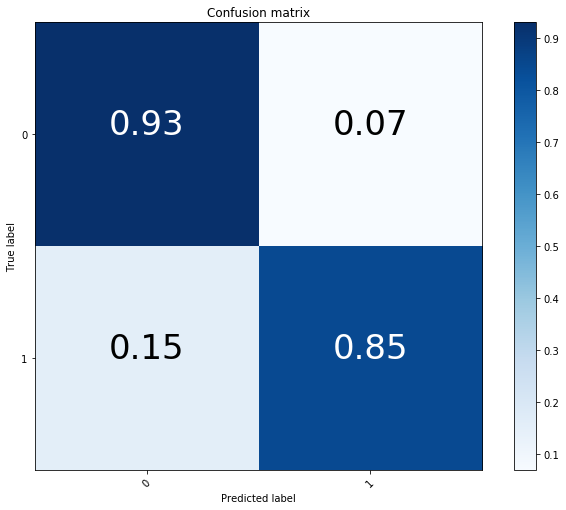

***** severe_toxic *****
Accuracy 0.9751709270481479
Precision 0.26066734074823056
Recall 0.8081504702194358


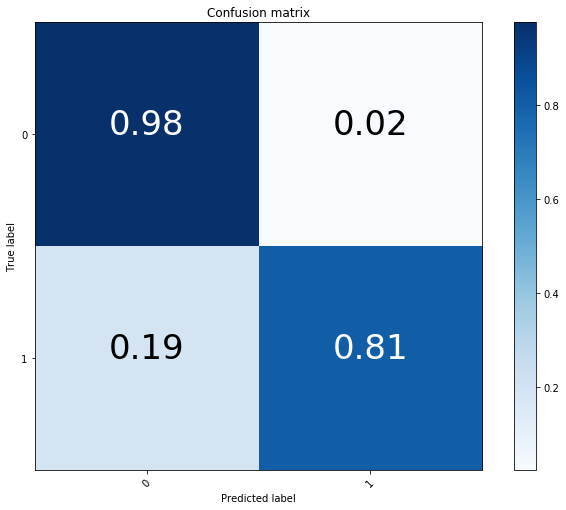

***** obscene *****
Accuracy 0.9590652436846294
Precision 0.5748886631768106
Recall 0.8708722925790034


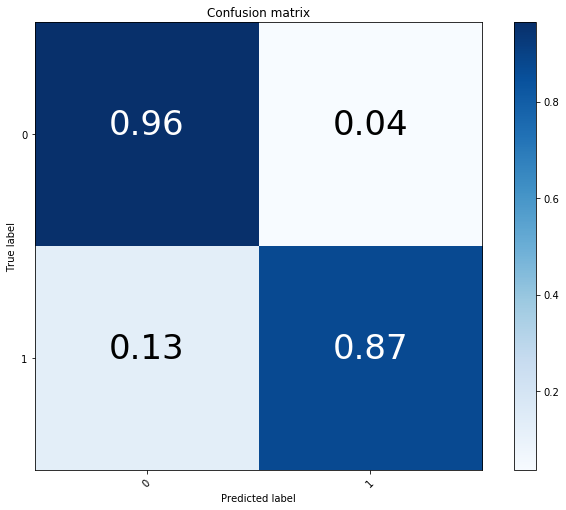

***** threat *****
Accuracy 0.9941656065325153
Precision 0.2968609865470852
Recall 0.6924686192468619


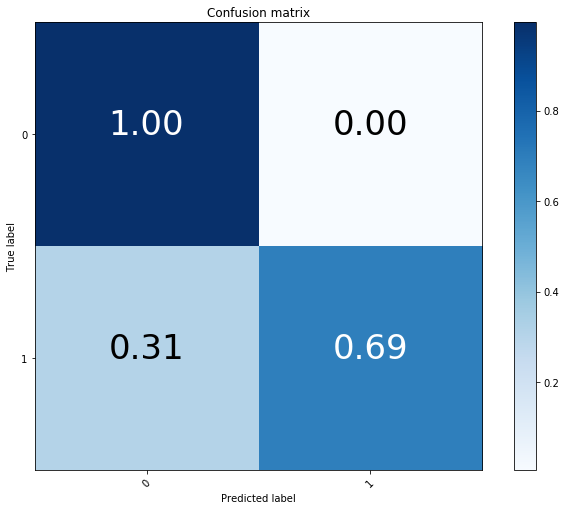

***** insult *****
Accuracy 0.9526543043535479
Precision 0.5123579981578139
Recall 0.8474038339469341


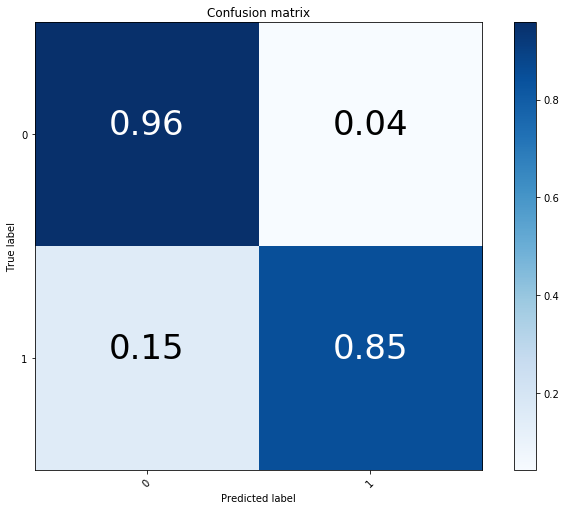

***** identity_hate *****
Accuracy 0.9679766373589186
Precision 0.1759664159524226
Recall 0.7160142348754448


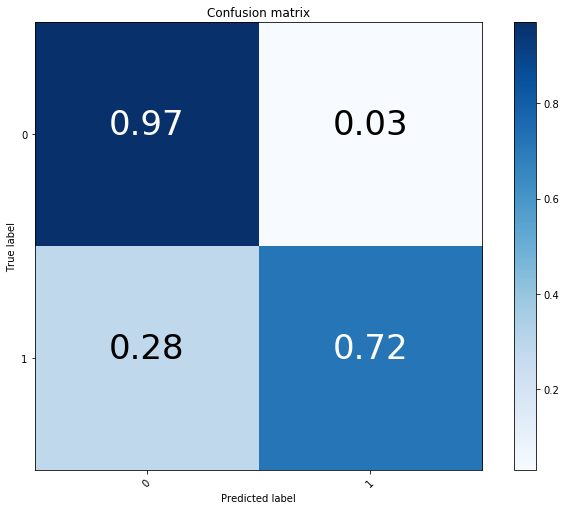

In [84]:
show_scores(Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('adasyn', SMOTE(ratio="minority")),
    ('logreg', LogisticRegression())
]))

***** toxic *****
Accuracy 0.9391806781934061
Precision 0.6512748335408434
Recall 0.7866483588335295


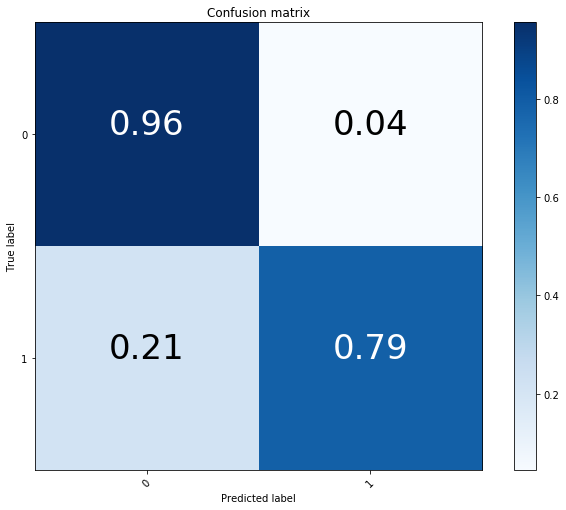

***** severe_toxic *****
Accuracy 0.9829605630095694
Precision 0.30056777856635913
Recall 0.5310344827586206


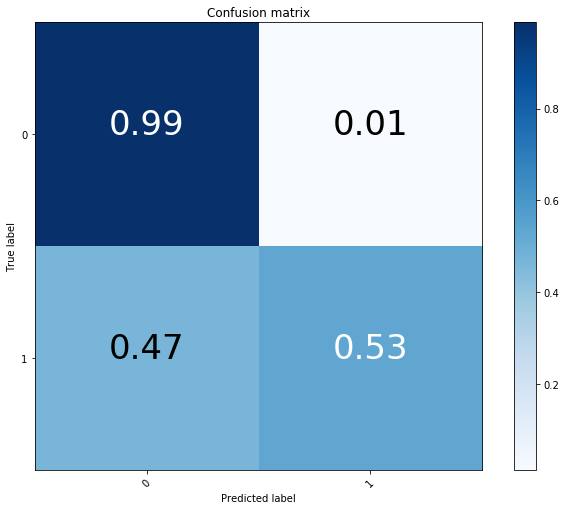

***** obscene *****
Accuracy 0.9649811055893615
Precision 0.6318797824283212
Recall 0.8112202627529885


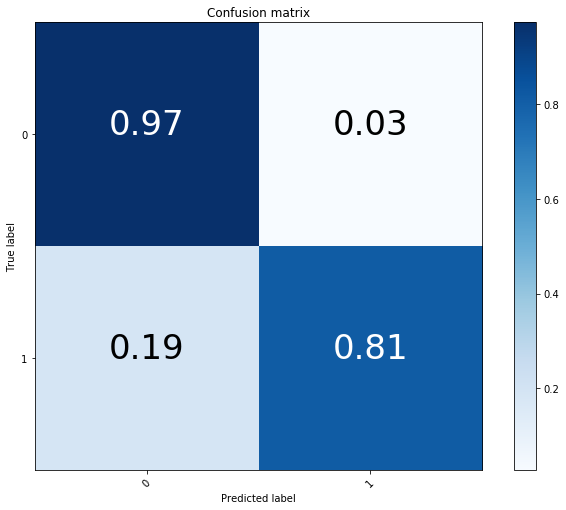

***** threat *****
Accuracy 0.9972426067393197
Precision 0.5703703703703704
Recall 0.32217573221757323


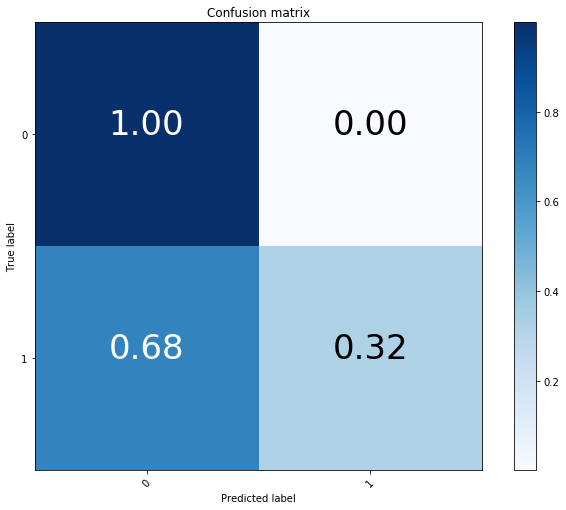

***** insult *****
Accuracy 0.9574734757568731
Precision 0.5511102782722759
Recall 0.746730988955186


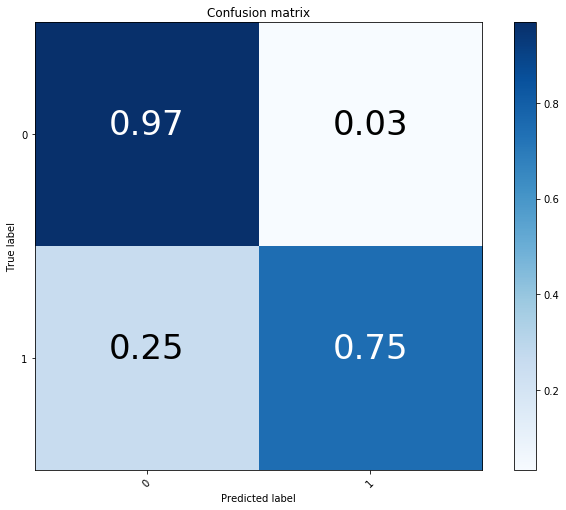

***** identity_hate *****
Accuracy 0.9845021965144043
Precision 0.266199649737303
Recall 0.4327402135231317


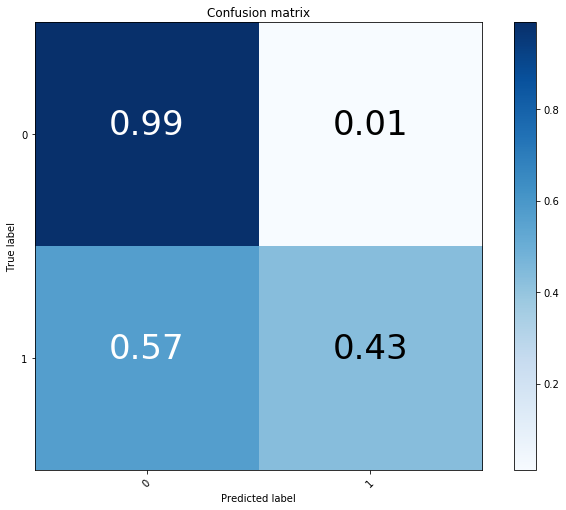

In [85]:
show_scores(Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('adasyn', SMOTE(ratio="minority")),
    ('svc', CalibratedClassifierCV(LinearSVC()))
]))

In [70]:
def submission(pipeline_arr, name, x = X, y = Y):
    predictions = []
    
    for tag in tags:
        print('*****',tag,'*****')
        pipeline = Pipeline(pipeline_arr)
        
        model = pipeline.fit(x, y[tag])
    
        predictions.append(model.predict_proba(test.comment_text)[:,1])
        
    submit_file = pd.DataFrame(np.array(predictions).T, columns=tags, index=test.id)
    submit_file.to_csv('../Submissions/' + name)
    
    print('DONE.')

In [73]:
submission([
    ('tfidf', TfidfVectorizer()),
    ('adasyn', SMOTE(ratio="minority")),
    ('logreg', LogisticRegression())
], 'TFIDF+SMOTE+Logistic-Regression.csv')

***** toxic *****
***** severe_toxic *****
***** obscene *****
***** threat *****
***** insult *****
***** identity_hate *****
DONE.


# Резултат: 0.9618 - Слабо представяне

In [86]:
submission([
    ('tfidf', TfidfVectorizer()),
    ('adasyn', SMOTE(ratio="minority")),
    ('logreg', CalibratedClassifierCV(LinearSVC()))
], 'TFIDF+SMOTE+SVM.csv')

***** toxic *****
***** severe_toxic *****
***** obscene *****
***** threat *****
***** insult *****
***** identity_hate *****
DONE.


# Резултат: 0.9437 - Най-лошия до сега...

In [87]:
logreg = pd.read_csv('../Submissions/TFIDF+SMOTE+Logistic-Regression.csv')
logreg[:10]

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.999866,0.438688,0.999977,0.732701,0.997387,0.838658
1,0000247867823ef7,0.004095,0.000748,0.001368,0.000240,0.003325,0.002220
2,00013b17ad220c46,0.655150,0.240186,0.539034,0.002889,0.489849,0.464708
3,00017563c3f7919a,0.001538,0.001174,0.001705,0.001403,0.003274,0.000390
4,00017695ad8997eb,0.315483,0.069725,0.153372,0.005337,0.104711,0.093890
5,0001ea8717f6de06,0.018196,0.002364,0.008983,0.003380,0.023333,0.004958
6,00024115d4cbde0f,0.004017,0.000307,0.004410,0.000398,0.007444,0.000719
7,000247e83dcc1211,0.955080,0.016213,0.346190,0.006450,0.413354,0.031373
8,00025358d4737918,0.008398,0.001055,0.010205,0.001814,0.003376,0.001935
9,00026d1092fe71cc,0.004884,0.000754,0.005477,0.001014,0.015322,0.003047


In [88]:
svm = pd.read_csv('../Submissions/TFIDF+SMOTE+SVM.csv')
svm[:10]

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.999998,1.305249e-05,9.999995e-01,1.062357e-03,0.987468,3.129257e-02
1,0000247867823ef7,0.000049,4.460480e-09,5.317229e-07,7.396084e-14,0.000007,7.824932e-08
2,00013b17ad220c46,0.641372,7.364347e-02,5.554946e-01,6.652309e-12,0.476021,4.293908e-01
3,00017563c3f7919a,0.000011,2.894903e-08,4.864989e-06,8.298830e-13,0.000015,7.874401e-10
4,00017695ad8997eb,0.017543,2.701006e-03,5.165371e-03,1.052540e-10,0.003343,1.111182e-04
5,0001ea8717f6de06,0.000518,3.847360e-08,6.891898e-04,1.081388e-11,0.000719,7.817812e-07
6,00024115d4cbde0f,0.000019,1.248686e-09,6.321487e-06,4.944159e-15,0.000069,3.443052e-09
7,000247e83dcc1211,0.915383,2.338654e-05,7.469787e-02,8.946207e-12,0.201582,2.768128e-05
8,00025358d4737918,0.000031,1.189263e-08,3.911389e-05,3.191085e-11,0.000004,1.736083e-07
9,00026d1092fe71cc,0.000041,7.055016e-10,9.949503e-06,8.308358e-14,0.000238,4.312488e-08


In [89]:
combined = (logreg.drop('id', axis=1) + svm.drop('id', axis=1)) / 2
combined.index = logreg['id']
combined[:10]

,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,
00001cee341fdb12,0.999932,0.219351,0.999988,0.366881,0.992427,0.434975
0000247867823ef7,0.002072,0.000374,0.000684,0.000120,0.001666,0.001110
00013b17ad220c46,0.648261,0.156915,0.547265,0.001445,0.482935,0.447050
00017563c3f7919a,0.000774,0.000587,0.000855,0.000701,0.001644,0.000195
00017695ad8997eb,0.166513,0.036213,0.079269,0.002669,0.054027,0.047000
0001ea8717f6de06,0.009357,0.001182,0.004836,0.001690,0.012026,0.002479
00024115d4cbde0f,0.002018,0.000154,0.002208,0.000199,0.003757,0.000360
000247e83dcc1211,0.935232,0.008118,0.210444,0.003225,0.307468,0.015700
00025358d4737918,0.004214,0.000527,0.005122,0.000907,0.001690,0.000968


In [91]:
combined.to_csv('../Submissions/SMOTE+TFIDF+LOGREG+SVM.csv')

# Резултат: 0.9574 - Този подход не дава добри резултати